In [14]:
%matplotlib inline

In [3]:
from linescanning import (
    prf,
    optimal,
    pycortex,
)
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, wilcoxon, ttest_rel
import os
import pandas as pd
import seaborn as sns
import cortex as cx
import matplotlib.pyplot as plt
import nibabel as nib
from statsmodels.stats.weightstats import ttest_ind, DescrStatsW
import random

opd = os.path.dirname
opj = os.path.join

In [4]:
conditions = {
    'sub-001': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-002': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-003': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-004': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-005': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-007': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-008': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-010': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-012': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-013': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-015': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-016': {'memantine': 'ses-2', 'placebo': 'ses-3'}
}

minr2=0.3
minecc=0.5 #The minimum
maxecc=4.5 #The maximum eccentricity you want to use
deriv='/data1/projects/Meman1/projects/pilot/derivatives'

In [5]:
class get_basic_params:
    # Class to do some filtering on a pRFmodelFitting object on Gaussian model. You mainly specify the eccentricities that you want to look at, your minimum r2, and potentially a ROI

    def __init__(self,
                 pRFmodelFitting=None,
                 data=None,
                 design=None,
                 model=None,
                 stage=None,
                 params=None,
                 roi=None,
                 eccmask=[minecc, maxecc],
                 r2mask=minr2):
        
        self.pRFmodelFitting=pRFmodelFitting
        if isinstance(self.pRFmodelFitting, prf.pRFmodelFitting):
            # if pRFmodelFitting object, get the necessary settings from here
            self.data=self.pRFmodelFitting.data
            self.model=self.pRFmodelFitting.model
            self.stage=self.pRFmodelFitting.stage
            self.params=prf.Parameters(params=getattr(self.pRFmodelFitting, f"{self.model}_{self.stage}"), model=self.model).to_df()
            self.design=self.pRFmodelFitting.design_matrix

        else:
            # else, take from manual input
            self.data=data
            self.model=model
            self.stage=stage
            self.params=params
            self.design=design
            
        # some additional settings
        self.eccmask=eccmask
        self.r2mask=r2mask
        self.roi=roi

        # select vertices based on roi...
        if self.roi is not None:
            try:
                self.params=self.params.loc[self.roi]
                print("ROI has", len(self.roi), "values")
            except:
                print("Not a valid ROI, give an array with vertex numbers for the ROI")
                print(len(self.roi))
                
        # drop vertices based on eccentricity and r2 boundaries
        self.params.loc[self.params['ecc'].values < self.eccmask[0]] = np.nan
        self.params.loc[self.params['ecc'].values > self.eccmask[1]] = np.nan
        self.params.loc[self.params['r2'].values < self.r2mask] = np.nan

        print("Excluding", self.params.isna().any(axis=1).sum(), 'vertices based on mask...')
        
        self.params=self.params.dropna()
        self.params=self.params[['x','y','r2']]


Loop and save everything:

In [6]:
# Here, I will store all output after looping over the subjects
prffits = {
    sub: {
        'fits': {'placebo': {'gauss': None, 'norm': None}, 'memantine': {'gauss': None, 'norm': None}},
        'roi_vertices': {'V1_vertices': None, 'V2_vertices': None, 'V3_vertices': None}
    } for sub in conditions.keys()}

for sub in conditions.keys():
    print(f"Working on subject {sub}...")
    print("")


    #######################################################
    ###### LOADING IN ROIs ################
    #######################################################

    print("Getting ROI vertices...")
    print("")

    finalrois= opj(deriv, 'freesurfer',sub, 'customlabel', 'roidrawing', 'final')
    
    #Load V1 vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
    V1_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V1.label'))
    V2_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V2.label'))
    V3_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V3.label'))

    all_lh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'lh.inflated'))

    #Load V1 vertices from right hemisphere. 
    V1_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V1.label'))
    V2_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V2.label'))
    V3_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V3.label'))

    all_rh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'rh.inflated'))

    # Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
    V1_rh = V1_rh + len(all_lh[0])
    V2_rh = V2_rh + len(all_lh[0])
    V3_rh = V3_rh + len(all_lh[0])

    # Concatenate the 2 and sort them such that they are in the right order
    V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
    V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
    V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))

    roi_vertices = np.sort(np.concatenate([V1_vertices, V2_vertices, V3_vertices]))

    prffits[sub]['roi_vertices']['V1_vertices'] = V1_vertices
    prffits[sub]['roi_vertices']['V2_vertices'] = V2_vertices
    prffits[sub]['roi_vertices']['V3_vertices'] = V3_vertices

    for condition in ['placebo', 'memantine']:
        print(f"Working on {condition}...")
        print("")

        # First, get path to the appropriate files
        design = prf.read_par_file(opj(deriv, 'prf', sub, 'design_task-2R.mat'))
        outputdata = opj('/data1/projects/Meman1/projects/pilot/code/floris/output', sub)

        # Load data
        data = np.load(opj(deriv, 'prf', sub, conditions[sub][condition], f'{sub}_{conditions[sub][condition]}_task-2R_hemi-LR_desc-avg_bold.npy'))

        # Initialize empty array of parameters with the appropriate shape
        params_norm = np.zeros(shape=(data.shape[1], 12))
        params_gauss = np.zeros(shape=(data.shape[1], 8))

        #######################################################
        ###### GETTING ALL PARAMETERS IN RIGHT SPOT ###########
        #######################################################

        print("Putting parameters in right place...")
        print("")

        # NORM
        for i in range(20):
            roivertices = np.load(opj(outputdata, 'roivertices', f'roivertices_{sub}_slice-{i}.npy'))
            paramss= np.load(opj(outputdata, 'fits', f'{sub}_{conditions[sub][condition]}_task-2R_model-norm_stage-iter_desc-prfparams_slice-{i}.npy'))

            for index, roivertex in enumerate(roivertices):
                params_norm[roivertex] = paramss[index]

        # GAUSS
        for i in range(20):
            roivertices = np.load(opj(outputdata, 'roivertices', f'roivertices_{sub}_slice-{i}.npy'))
            paramss= np.load(opj(outputdata, 'fits', f'{sub}_{conditions[sub][condition]}_task-2R_model-gauss_stage-iter_desc-prfparams_slice-{i}.npy'))

            for index, roivertex in enumerate(roivertices):
                params_gauss[roivertex] = paramss[index]

        #######################################################
        ###### LOADING IN PARAMETERS IN OBJECT ################
        #######################################################
        print("Creating pRFmodelFitting object...")
        print("")
        
        # initialize empty model
        norm_obj= prf.pRFmodelFitting(
            data.T,
            design_matrix=design,
            TR=1.5,                     # default
            model='norm',                # default, can be 'gauss', 'css', 'dog', 'norm'
            stage="iter",               # default
            verbose=True,               # keep track of what we're doing,
            fix_bold_baseline=True      # fix the BOLD baseline at 0
        )

        # load params
        norm_obj.load_params(params_norm, model='norm', stage="iter")


        # initialize empty model
        gauss_obj= prf.pRFmodelFitting(
            data.T,
            design_matrix=design,
            TR=1.5,                     # default
            model='gauss',                # default, can be 'gauss', 'css', 'dog', 'norm'
            stage="iter",               # default
            verbose=True,               # keep track of what we're doing,
            fix_bold_baseline=True      # fix the BOLD baseline at 0
        )

        # load params
        gauss_obj.load_params(params_gauss, model='gauss', stage="iter")


        #######################################################
        ###### CREATING AN ADD_PRF_PROFILE OBJ ################
        #######################################################
        print("Creating an Add_pRF_profile...")
        print("")

        norm_filtered = get_basic_params(norm_obj, r2mask=0.3, eccmask=[0.5, 4.5], roi=roi_vertices) # You can change things here in the settings if you want
        gauss_filtered = get_basic_params(gauss_obj, r2mask=0.3, eccmask=[0.5, 4.5], roi=roi_vertices) # You can change things here in the settings if you want

        #######################################################
        ###### ADDING TO DICTIONARY NOW     ###################
        #######################################################

        prffits[sub]['fits'][condition]['norm'] = norm_filtered
        prffits[sub]['fits'][condition]['gauss'] = gauss_filtered

Working on subject sub-001...

Getting ROI vertices...

Working on placebo...

Putting parameters in right place...

Creating pRFmodelFitting object...

Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/projects/pilot/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f45463a0df0>
Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/pro

In [7]:
list_of_dfs = []

for sub in conditions.keys():
    for condition in ['placebo', 'memantine']:
        params_gauss = prffits[sub]['fits'][condition]['gauss'].params
        params_norm = prffits[sub]['fits'][condition]['norm'].params

        valid_vertices = sorted(list(set(params_gauss.index).intersection(set(params_norm.index))))

        params_gauss_valid = params_gauss.loc[valid_vertices]
        params_norm_valid = params_norm.loc[valid_vertices]

        datasub = pd.merge(params_gauss_valid, params_norm_valid, left_index=True, right_index=True, suffixes=['_gauss','_norm'])
        datasub['sub'] = sub
        datasub['condition'] = condition

        list_of_dfs.append(datasub)

basic_params_collection = pd.concat(list_of_dfs, ignore_index=True)

In [8]:
from scipy.stats import pearsonr

In [9]:
corrcoef_x = pearsonr(basic_params_collection['x_gauss'].values, basic_params_collection['x_norm'].values)
corrcoef_y = pearsonr(basic_params_collection['y_gauss'].values, basic_params_collection['y_norm'].values)
corrcoef_r2 = pearsonr(basic_params_collection['r2_gauss'].values, basic_params_collection['r2_norm'].values)

In [10]:
corrcoef_x

PearsonRResult(statistic=0.9987821531414856, pvalue=0.0)

In [11]:
corrcoef_y

PearsonRResult(statistic=0.9980982975983701, pvalue=0.0)

In [12]:
corrcoef_r2

PearsonRResult(statistic=0.9155883530592587, pvalue=0.0)

In [13]:
basic_params_collection

,x_gauss,y_gauss,r2_gauss,x_norm,y_norm,r2_norm,sub,condition
0,0.409005,-2.886873,0.575448,0.404449,-2.756808,0.709162,sub-001,placebo
1,0.432736,-2.675978,0.513983,0.430786,-2.535103,0.604947,sub-001,placebo
2,0.231145,-2.653690,0.303875,0.369163,-2.529465,0.337962,sub-001,placebo
3,0.662121,-3.890913,0.622861,0.710376,-3.752263,0.732057,sub-001,placebo
4,0.535441,-3.602783,0.692431,0.541799,-3.446648,0.781001,sub-001,placebo
...,...,...,...,...,...,...,...,...
138522,-1.226995,3.077841,0.608786,-1.251097,3.094770,0.784286,sub-016,memantine
138523,-1.166721,-2.326949,0.828385,-1.086850,-1.982230,0.857475,sub-016,memantine
138524,-2.097421,-0.516265,0.756246,-1.991258,-0.490995,0.780067,sub-016,memantine
138525,-3.661143,-0.799423,0.869557,-3.539448,-0.755788,0.894092,sub-016,memantine


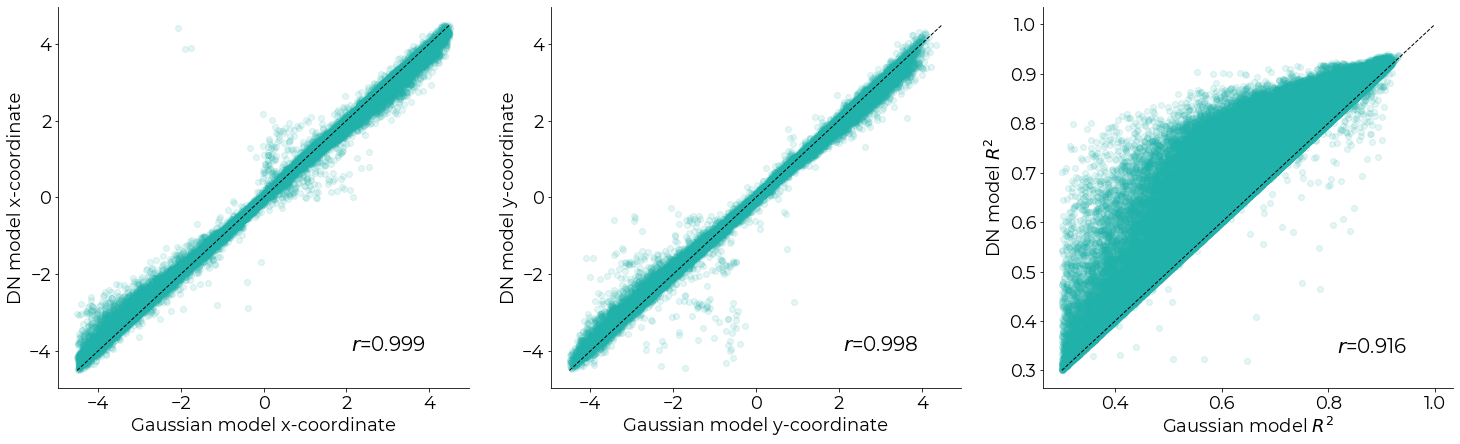

In [17]:
fig, ax = plt.subplots(1,3, figsize=(25,7))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})

ax[0].scatter(basic_params_collection['x_gauss'].values, basic_params_collection['x_norm'].values, alpha = 0.12, color='lightseagreen')
ax[0].set_xlabel("Gaussian model x-coordinate", fontsize=18)
ax[0].set_ylabel("DN model x-coordinate", fontsize=18)
ax[0].plot(np.linspace(-4.5,4.5,1000), np.linspace(-4.5,4.5,1000), linestyle='--', color='black', linewidth=1)
ax[0].text(3,-4, f"$r$={round(corrcoef_x.statistic, 3)}", horizontalalignment='center', fontsize=20)

ax[1].scatter(basic_params_collection['y_gauss'].values, basic_params_collection['y_norm'].values, alpha = 0.12,color='lightseagreen')
ax[1].set_xlabel("Gaussian model y-coordinate", fontsize=18)
ax[1].set_ylabel("DN model y-coordinate", fontsize=18)
ax[1].plot(np.linspace(-4.5,4.5,1000), np.linspace(-4.5,4.5,1000), linestyle='--', color='black', linewidth=1)
ax[1].text(3,-4, f"$r$={round(corrcoef_y.statistic, 3)}", horizontalalignment='center', fontsize=20)

ax[2].scatter(basic_params_collection['r2_gauss'].values, basic_params_collection['r2_norm'].values, alpha = 0.12,color='lightseagreen')
ax[2].set_xlabel("Gaussian model $R^2$", fontsize=18)
ax[2].set_ylabel("DN model $R^2$", fontsize=18)
ax[2].plot(np.linspace(0.3,1,1000), np.linspace(0.3,1,1000), linestyle='--', color='black', linewidth=1)
ax[2].text(0.883, 0.335, f"$r$={round(corrcoef_r2.statistic, 3)}", horizontalalignment='center', fontsize=20)

#fig.suptitle("Relationship between Gaussian and DN model fits per vertex", fontsize=25)

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/gauss_vs_norm_allvoxels.png"
plt.savefig(save_path, dpi=300)

sns.despine()
plt.show()

In [18]:
print("Mean R2 of Gaussian model:", np.mean(basic_params_collection['r2_gauss']), 'std', np.std(basic_params_collection['r2_gauss']))
print("Mean R2 of Gaussian model:", np.mean(basic_params_collection['r2_norm']), 'std', np.std(basic_params_collection['r2_norm']))

Mean R2 of Gaussian model: 0.6894883907077599 std 0.13158495233246664
Mean R2 of Gaussian model: 0.7404942849540193 std 0.12213123430580713


In [19]:
from scipy import stats

In [20]:
test = stats.ttest_rel(basic_params_collection['r2_gauss'], basic_params_collection['r2_norm'])

In [68]:
test

Ttest_relResult(statistic=-358.60433314106876, pvalue=0.0)

In [21]:
cohen_d = test.statistic/np.sqrt(138527)

In [22]:
abs(cohen_d)

0.9634924558157318

Now, plot representative vertex:

In [27]:
prffits['sub-013']['fits']['placebo']['norm'].pRFmodelFitting

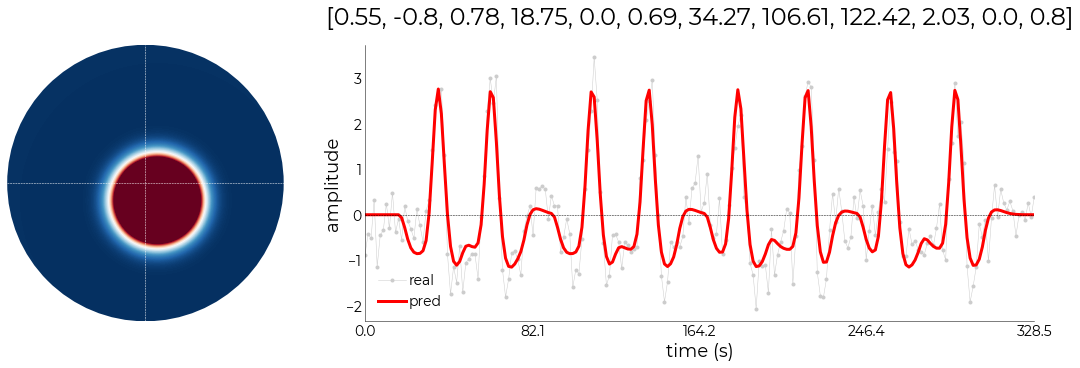

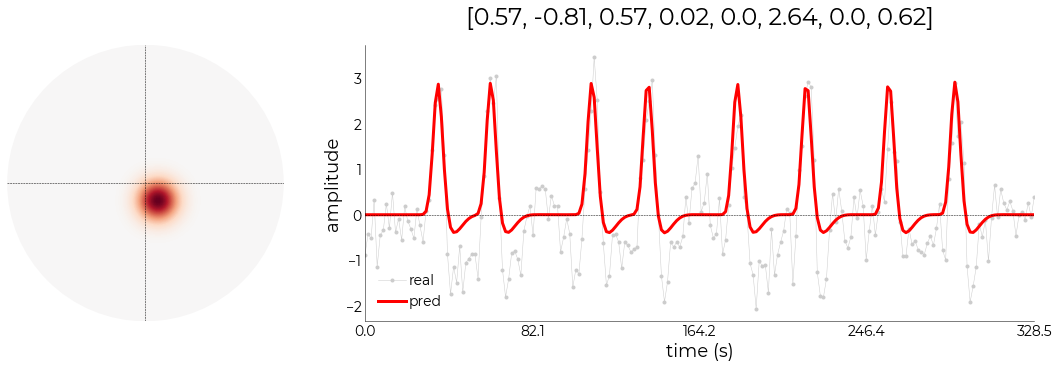

In [39]:
norm_plac = prffits['sub-013']['fits']['placebo']['norm'].pRFmodelFitting
gauss_plac = prffits['sub-013']['fits']['placebo']['gauss'].pRFmodelFitting

_, _, _, prednormplac, = norm_plac.plot_vox(vox_nr=0, title="pars", model='norm')
_, _, _, predgaussplac, = gauss_plac.plot_vox(vox_nr=0, title="pars")

dataplacebo = norm_plac.data

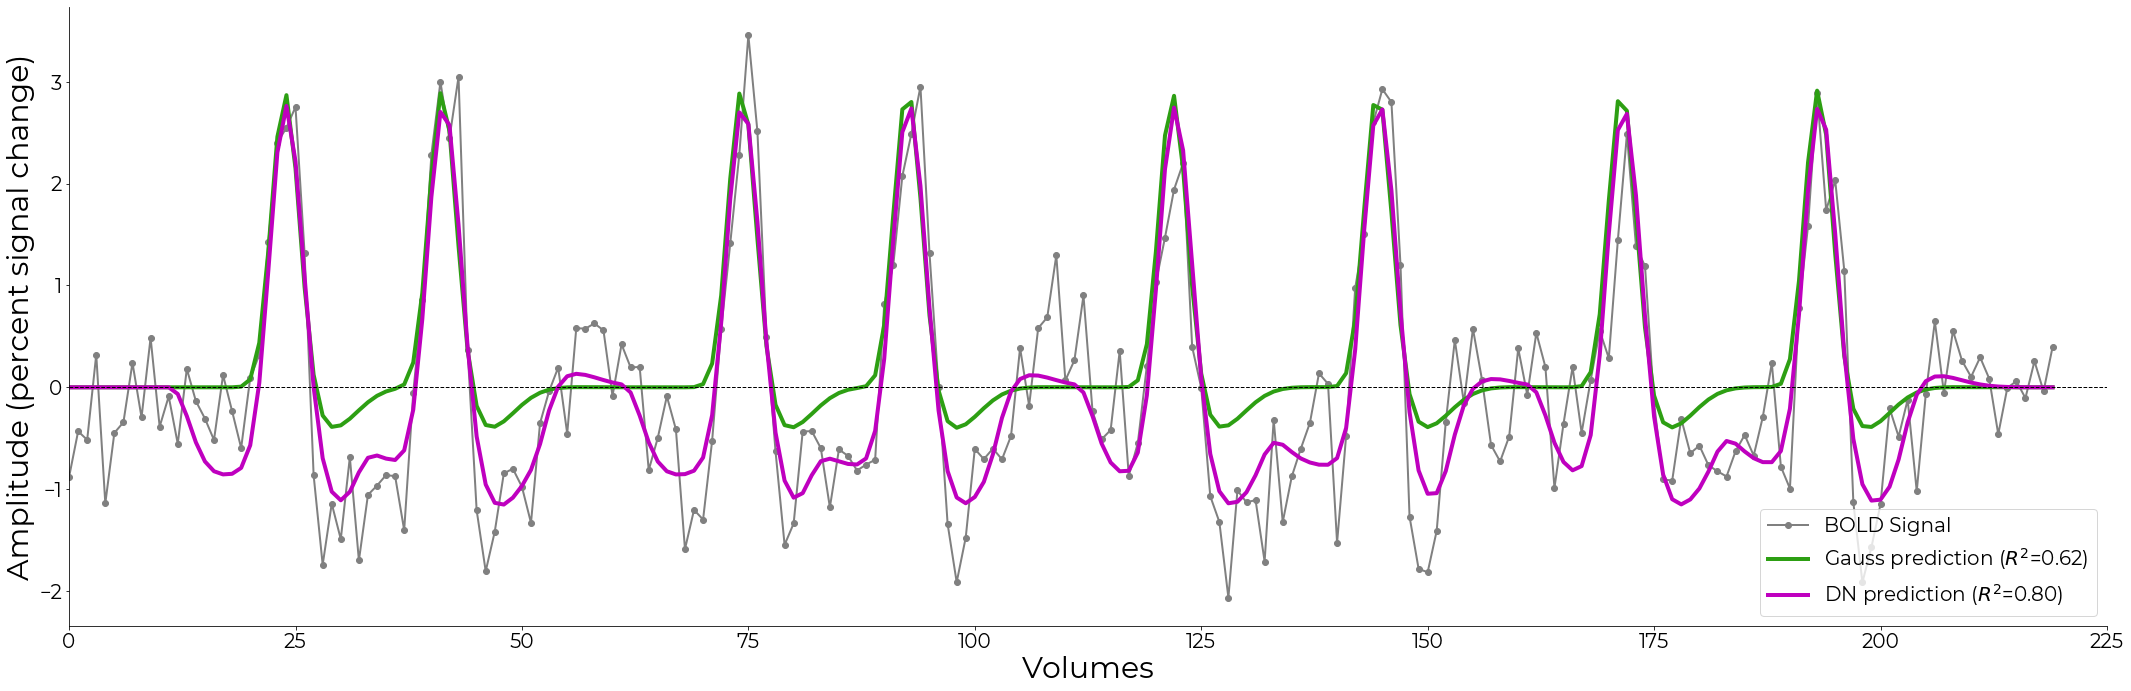

In [42]:
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 20})

# Create the plot
plt.figure(figsize=(30, 10))  # Convert width from cm to inches

# Plot the actual BOLD signal
plt.plot(dataplacebo[0, :], 'o-', color='grey', linewidth=2, label='BOLD Signal')

# Plot the predictions
plt.plot(predgaussplac, '-', color='#2d9f13', linewidth=4, label='Gauss prediction ($R^2$=0.62)')
plt.plot(prednormplac, '-', color='m', linewidth=4, label='DN prediction ($R^2$=0.80)')

# Add labels and legend
plt.xlabel('Volumes', fontsize=30)
plt.ylabel('Amplitude (percent signal change)', fontsize=30)
plt.hlines(0, xmin=0, xmax=225, color='black',linestyle='--', linewidth=1)
plt.xlim(0, 225)
plt.tight_layout()
sns.despine()
plt.legend()

savepath = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/gauss_vs_dn.png"
plt.savefig(savepath,dpi=300)

# Show the plot
plt.show()